In [1]:
#Wir importieren die benötigten Bibliotheken
import importlib as imp
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import sympy
import matplotlib.pyplot as plt

import pysim
import mimo
import gantry as module_gantry #avoid name-clash

#Liste der Ruhelagen
equis=[[0.0,0.0],[0.0,0.3],[0.8,0.0],[0.8,0.3]]

# 1 Modell des Portals
## 1.1 Nichtlineares Modell 
### 1.1.1 Modellgleichungen
\begin{gather}
\newcommand{\vect}[1]{\boldsymbol{#1}}\small
\left[\begin{matrix}m + M & 0 & - m \left(x_1 \sin{\left(\varphi \right)} + x_2 \cos{\left(\varphi \right)}\right)\\0 & m + M & m \left(x_1 \cos{\left(\varphi \right)} - x_2 \sin{\left(\varphi \right)}\right)\\- m \left(x_1 \sin{\left(\varphi \right)} + x_2 \cos{\left(\varphi \right)}\right) & m \left(x_1 \cos{\left(\varphi \right)} - x_2 \sin{\left(\varphi \right)}\right) & J_{R} + m \left(x_1^{2} + x_2^{2}\right)\end{matrix}\right]\begin{bmatrix}\dot{z}_1\\\dot{z}_2\\\dot\varphi\end{bmatrix}=-\left[\begin{matrix}m \cos{\left(\varphi \right)} & - m \sin{\left(\varphi \right)}\\m \sin{\left(\varphi \right)} & m \cos{\left(\varphi \right)}\\- m x_2 & m x_1\end{matrix}\right]\begin{bmatrix}\dot x_1\\\dot x_2\end{bmatrix}+\begin{bmatrix}p_1\\p_2\\p_\varphi\end{bmatrix}\\
\begin{bmatrix}\dot{p}_1\\\dot{p}_2\\\dot{p}_\varphi\end{bmatrix}=\left[\begin{matrix}- 4 k z_1\\- 4 k z_2\\(- \dot{\varphi} \dot{z}_1 m x_1 - \dot{\varphi} \dot{z}_2 m x_2- \dot{z}_1 \dot{x}_2 m  + \dot{x}_1 \dot{z}_2 m)\cos{\left(\varphi \right)} + (\dot{\varphi} \dot{z}_1 m x_2 - \dot{\varphi} \dot{z}_2 m x_1 - \dot{z}_1 \dot{x}_1 m  - \dot{z}_2 \dot{x}_2 m  - 4 k l^{2})\sin{\left(\varphi \right)} \end{matrix}\right]\\
\ddot{x}_1={u}_1\\
\ddot{x}_2={u}_2
\end{gather}
Als Zustand für die Implementierung soll der Vektor
\begin{equation}\boldsymbol{x}=
\begin{bmatrix}
x_1\\x_2\\x_3\\x_4\\x_5\\x_6\\x_7\\x_8\\x_9\\x_{10}
\end{bmatrix}=\begin{bmatrix}
x_1\\x_2\\z_1\\z_2\\\varphi\\ \dot{x}_1\\\dot{x}_2\\p_1\\p_2\\ p_{\varphi}
\end{bmatrix}
\end{equation}
verwendet werden.
Zur Auswertung der Zustandsdifferentialgleichungen ist es sinnvoll, zunächst $\dot{z}_1$, $\dot{z}_2$, und $\dot\varphi$ zu berechnen und dann in die Gleichungen für $\dot{p}_1$, $\dot{p}_2$, und $\dot{p}_\varphi$  einzusetzen, um Mehrfachauswertungen von längeren Ausdrücken zu vermeiden.

### 1.1.2. Nichtlineares Modell

#### Test des nichtlinearen Modells

Lösen vor Ausführung der Zellen die Aufgabe 1a).

In [2]:
#Module neu laden
import gantry as module_gantry
imp.reload(module_gantry)

#Modell
from gantry import Gantry

#Modell anlegen
gantry=Gantry()

#Auswerten
gantry.verify_model('testdata.pckl')

Maximaler absolutier Fehler in Modellgleichungen (euklidische Norm): 2.8422577837666363e-14
Maximaler relativer Fehler in Modellgleichung (euklidische Norm): 1.2755751311762198e-16
Maximaler absolutier Fehler in Modellgleichungen (komponentenweise):


array([[0.00000000e+00],
       [0.00000000e+00],
       [1.38777878e-17],
       [6.93889390e-18],
       [2.22044605e-16],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.84217094e-14]])

Maximaler absoluter Fehler in Ausgang accell_frame (euklidische Norm): 7.32410687763558e-15
Maximaler relativer Fehler in Ausgang accell_frame (euklidische Norm): 2.330888066960246e-16
Maximaler absoluter Fehler in Ausgang accell_frame (komponententweise):
[[7.10542736e-15]
 [3.55271368e-15]]
Maximaler absoluter Fehler in Ausgang gyro_frame (euklidische Norm): 2.220446049250313e-16
Maximaler relativer Fehler in Ausgang gyro_frame (euklidische Norm): 4.951120101508788e-16
Maximaler absoluter Fehler in Ausgang gyro_frame (komponententweise):
[[2.22044605e-16]]
Maximaler absoluter Fehler in Ausgang position_axis (euklidische Norm): 0.0
Maximaler relativer Fehler in Ausgang position_axis (euklidische Norm): 0.0
Maximaler absoluter Fehler in Ausgang position_axis (komponententweise):
[[0.]
 [0.]]
Maximaler absoluter Fehler in Ausgang position_total (euklidische Norm): 3.1401849173675503e-16
Maximaler relativer Fehler in Ausgang position_total (euklidische Norm): 1.9194838066708638e-16
Maxim

#### Simulation des nichtlinearen Modells

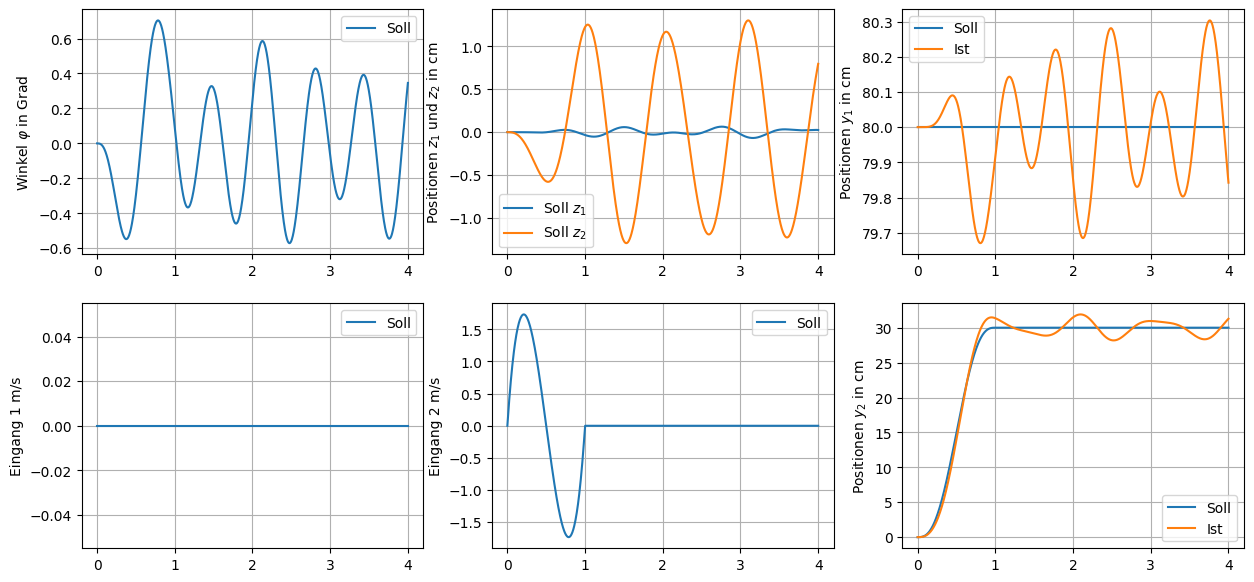

In [3]:
#Module neu laden
import gantry as module_gantry
imp.reload(module_gantry)

#Modell
from gantry import Gantry

#Einfacher polynomialer Übergang für den Schlitten
from gantry import RigidTrajectory 

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results

#Modell anlegen
gantry=Gantry()

# Anfangs- und Endwerte für die Schlittenposition (absolut) 
ya = np.array(equis[2])
yb = np.array(equis[3])

#Anfangsbedingungen
x0 = np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=4*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,1000)

trajectory_rigid=RigidTrajectory(ya,yb,T,[2,2])

#Regler ist Steuerung
gantry.connect("accell_axis", trajectory_rigid, "u_ref")

#Simulation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,  #Zeit
             (x,),#Zustand
             (trajectory_rigid.input(t_eval),),#Eingangsverläufe (Soll, Ist)
                         (trajectory_rigid.state(t_eval),
                          gantry.output(t_eval,x,'position_total')) #Absolutposition Schlitten (Soll,Ist) 
            )

## 1.2 Lineares Modell des Systems

Lösen Sie vor Ausführung des nachfolgenden Codes die Aufgabe 1b). Dokumentieren Sie Ihre Überlegungen in dieser Zelle.

### 1.2.1. Modellgleichungen

##### Ruhelage:

Alle Größen verschwinden identisch bis auf 
\begin{align}
x_1=x_{10}\\
x_2=x_{20}\\
\end{align}

##### Ergänzen Sie bitte hier die linearisierten Gleichungen (Aufgabe 1b)

\begin{align}
\dot{\tilde{x}}_1 &= \tilde{x}_6 \\
\dot{\tilde{x}}_2 &= \tilde{x}_7 \\
\mathbf{M}(\bar{x})
\begin{bmatrix}
\dot{\tilde{z}}_1  \\ \dot{\tilde{z}}_2 \\ \dot{\tilde{\varphi}}
\end{bmatrix}
&= -
\begin{bmatrix}
m & 0 \\
0 & m \\
-m \overline{x}_2 & m \overline{x}_1
\end{bmatrix}
\begin{bmatrix}
\tilde{x}_6 \\ \tilde{x}_7
\end{bmatrix}
+
\begin{bmatrix}
\tilde{p}_1  \\ \tilde{p}_2 \\ \tilde{p}_\varphi
\end{bmatrix} \\
\dot{\tilde{x}}_6 &= \tilde{u}_1 \\
\dot{\tilde{x}}_7 &= \tilde{u}_2 \\
\dot{\tilde{p}}_1 &= -4k \tilde{z}_1 \\
\dot{\tilde{p}}_2 &= -4k \tilde{z}_2 \\
\dot{\tilde{p}}_{\varphi} &= -4k l^2 \tilde{\varphi} \\
\end{align}

\begin{align}
\tilde{y}_1 = \tilde{x}_1 + \tilde{z}_1 - \overline{x}_2 \cdot \tilde{\varphi} \\
\tilde{y}_2 = \tilde{x}_2 + \tilde{z}_2 + \overline{x}_1 \cdot \tilde{\varphi}
\end{align}

**Massenmatrix:**

$$
\mathbf{M}(\bar{x}) =
\begin{bmatrix}
m + M & 0 & - m \bar{x}_2\\
0 & m + M & m \bar{x_1} \\
- m \bar{x}_2 & m \bar{x_1} & J_{R} + m \left(\overline{x}_1^{2} + \overline{x}_2^{2}\right)
\end{bmatrix}
$$


In [4]:
#Modell linearisieren und Linearisierung überprüfen
#Module neu laden
import gantry as module_gantry
imp.reload(module_gantry)

#Modell
from gantry import Gantry

#Einfacher Polynomialer Übergang für den Schlitten
from gantry import RigidTrajectory 

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results

#Modell anlegen
gantry=Gantry()

#Linearisierungspunkt 4.Ruhelage
equi_lin=equis[3]

#Berechnung der Linearisierung
gantry_lin=gantry.linearize(equi_lin)

#Prüfen der Linearisierung
A,B,C,D=gantry.verify_linearization(gantry_lin)

Maximaler absoluter Fehler in Matrix A Zeile 10, Spalte 5 beträgt 3.3310243452433497e-11.
Maximaler relativer Fehler in Matrix A Zeile 10, Spalte 5 beträgt 1.6655121726219518e-13.
Maximaler absoluter Fehler in Matrix C_accell_frame Zeile 2, Spalte 5 beträgt 3.5793590313915047e-12.
Maximaler relativer Fehler in Matrix C_accell_frame Zeile 1, Spalte 5 beträgt 6.667659017508915e-13.
Maximaler absoluter Fehler in Matrix C_gyro_frame Zeile 1, Spalte 6 beträgt 1.3877787807814457e-17.
Maximaler relativer Fehler in Matrix C_gyro_frame Zeile 1, Spalte 6 beträgt 1.3785269222429027e-16.
Maximaler absoluter Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 2.8755664516211255e-11.
Maximaler relativer Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 2.8755664515384365e-11.
Maximaler absoluter Fehler in Matrix C_position_total Zeile 1, Spalte 5 beträgt 4.6884440774164204e-11.
Maximaler relativer Fehler in Matrix C_position_total Zeile 1, Spalte 5 beträgt 1.562814692716379e-10.
Maxi

### 1.2.2 Simulation des linearen Modells

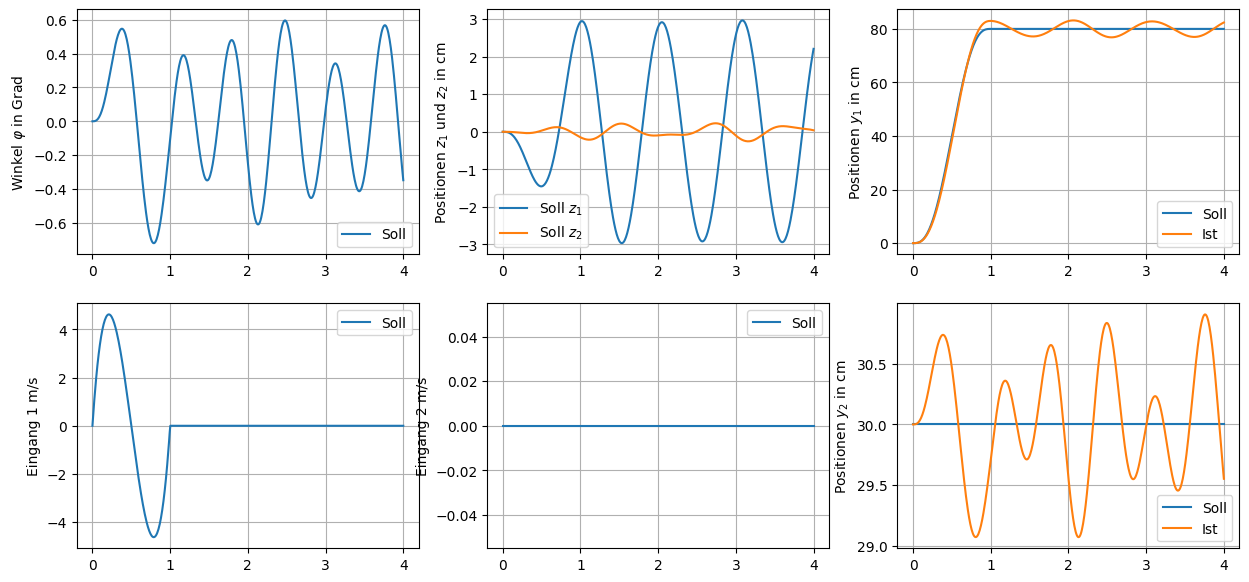

In [5]:
import gantry as module_gantry
imp.reload(module_gantry)

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results


#Anfangsbedingungen
x0 = np.array([equis[1][0],equis[1][1],0,0,0,0,0,0,0,0])

#Übergangszeit
T=1.0




#Simulationszeit
T_sim=4*T

#Steuerung definieren
trajectory_rigid=RigidTrajectory(equis[1],equis[3],T,[2,2])

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Eingang mit Steuerung verbinden 
gantry_lin.connect("accell_axis", trajectory_rigid, "u_ref")

#Simulation
res = solve_ivp(gantry_lin.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-8,rtol=1e-7 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,(x,),(trajectory_rigid.input(t_eval),),
             (trajectory_rigid.state(t_eval),gantry_lin.output(t_eval,x,'position_total')))

# 2 Regelungs- und Steuerungsentwurf

In [6]:
import mimo
imp.reload(mimo)
#equis=[[0.8,0.3]]

#Analyse der Beobachtbarkeit für die verschiedene Arbeitspunkte
for equi in equis:
    _gantry_lin=gantry.linearize(equi)

    #Systematrizen aufstellen
    _A=_gantry_lin.A()
    _B=_gantry_lin.B()

    print("Ruhelage:", equi)
    #Steuerbarkeit
    S=mimo.controllability_matrix(_A,_B)
    print("Rang Steuerbarkeit bei Messung der Schlittenposition:", np.linalg.matrix_rank(S))

    #Berechnung der Kronecker-Indizes
    kroneckers=mimo.kronecker(_A,_B)
    print("Mögliche Kronecker-Indizes:", kroneckers)

Ruhelage: [0.0, 0.0]
Rang Steuerbarkeit bei Messung der Schlittenposition: 8
Mögliche Kronecker-Indizes: [4 4]
Ruhelage: [0.0, 0.3]
Rang Steuerbarkeit bei Messung der Schlittenposition: 10
Mögliche Kronecker-Indizes: [6 4]
Ruhelage: [0.8, 0.0]
Rang Steuerbarkeit bei Messung der Schlittenposition: 10
Mögliche Kronecker-Indizes: [4 6]
Ruhelage: [0.8, 0.3]
Rang Steuerbarkeit bei Messung der Schlittenposition: 10
Mögliche Kronecker-Indizes: [6 4]


### Überlegungen
Wenn ein System nicht steuerbar ist, bedeutet dies, dass es nicht möglich ist, das System von einem bestimmten Anfangszustand in einen anderen gewünschten Endzustand zu bringen.In diesem Fall sind alle Ruhelagen bzw das System, das um die jeweilige Ruhelage linearisiert wird steuerbar. Bis auf die erste Ruhelage, da die Steuerbarkeitsmatrix nicht den Rang n der Zustandsdimensionen besitzt. Wir können also nicht einfach von der Ruhelage 1 in eine andere Ruhelage überführen.

## 2.1 Steuerungsentwurf 

In [7]:
#Module neu laden
import gantry as module_gantry
import pysim 
imp.reload(module_gantry)
imp.reload(pysim)

#Trajektorienplanung
from pysim import ContinuousFlatnessBasedTrajectory, ContinuousLinearizedSystem

#Funktion zum Anzeigen der Simulationsergebnisse
from gantry import plot_results, Gantry

#Modell anlegen
gantry=Gantry()

#Übergangszeit für Trajektorie
T = 1.0

#Linearisierungspunkt 4.Ruhelage
equi_lin=equis[3]

#Modell definieren
gantry_nl=Gantry()

#Linearisiertes Modell
gantry_lin=gantry_nl.linearize(equi_lin)

equis_trj={"position_total":{"start":equis[1],"final":equis[3]}}

#Generiere Solltrajektorien für das linearisierte System
trajectory=gantry_lin.rest_to_rest_trajectory(equis_trj,T,(4,6))


Zum Test der bisherigen Schritte wird die Planung mit der Simulation verglichen. Zumindest bei der Simulation mit dem linearen Modell sollten die geplanten und die simulierten Trajektorien jeweils übereinanderliegen.

### Simulation der Steuerung mit linearem oder nichtlinearem Modell

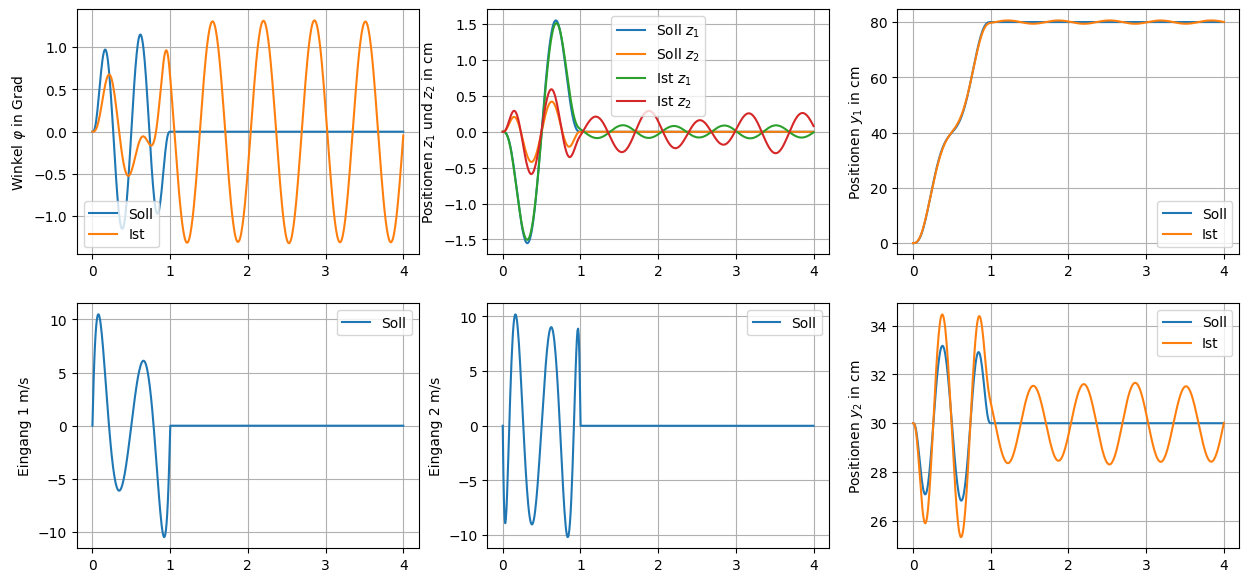

In [8]:
#Anfangszustand
x0=trajectory.state(0).flatten()

#Simulationszeit
Tsim=4

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

#Lineares oder nichtlineares Modell
linear = False
if linear:
    gantry=gantry_lin
else:
    gantry=gantry_nl

# Steuerung einbauen
gantry.connect('accell_axis',trajectory,'u_ref')

#Simlation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )
#Ergebnisse Plotten
x=res.y
a=plot_results(t_eval,
               (trajectory.state(t_eval),res.y),
               (trajectory.input(t_eval),),
               (trajectory.output(t_eval,'position_total'),gantry.output(t_eval,x,'position_total')))

## 2.2 Reglerentwurf mittels Eigenwertvorgabe 

### Berechnen der Reglerverstärkungen und Simulation des geschlossenen Regelkreises

### Wahl der Wunscheigenwerte

Reelle Eigenwerte werden einfach um -10 verschoben. Grundlage für die Berechnung der komplexen Eigenwerte ist die Formel für die Berechnung der Pole eines Schwingers:

$$
    s_{1,2} = -d \omega_g \pm j \sqrt{\omega_g^2 (1-d^2)}
$$
$$
    \mathrm{Im} = \sqrt{\omega_g^2 (1-d^2)} \Rightarrow \omega_g = \frac{\mathrm{Im}}{\sqrt{(1-d^2)}}
$$
$$
    \mathrm{Re} = -d \omega_g
$$

In [9]:
import warnings
warnings.filterwarnings("error")

#importiere benötigte Funktion
imp.reload(module_gantry)
imp.reload(pysim)
from gantry import Gantry
from pysim import ContinuousFlatnessBasedTrajectory, LinearStateFeedback

#Regler definieren 
######-------!!!!!!Aufgabe!!!!!!-------------########
##Hier bitte die Reglerverstärkung berechnen
A_eigs = np.linalg.eigvals(_A)
d = 0.5
for i in range(len(A_eigs)):
    if int(np.imag(A_eigs[i])):
        wg = A_eigs[i].imag / np.sqrt(1-d**2)
        Re = -1* np.abs(d*wg)
        A_eigs[i] = complex(Re,A_eigs[i].imag) 
    else:
        A_eigs[i] -= 10

eigs = [A_eigs[:4],A_eigs[4:]]

K_pole_placement = gantry_lin.acker(eigs)

######-------!!!!!!Aufgabe Ende !!!!!!-------------########


### Simulation des geschlossenen Regelkreises

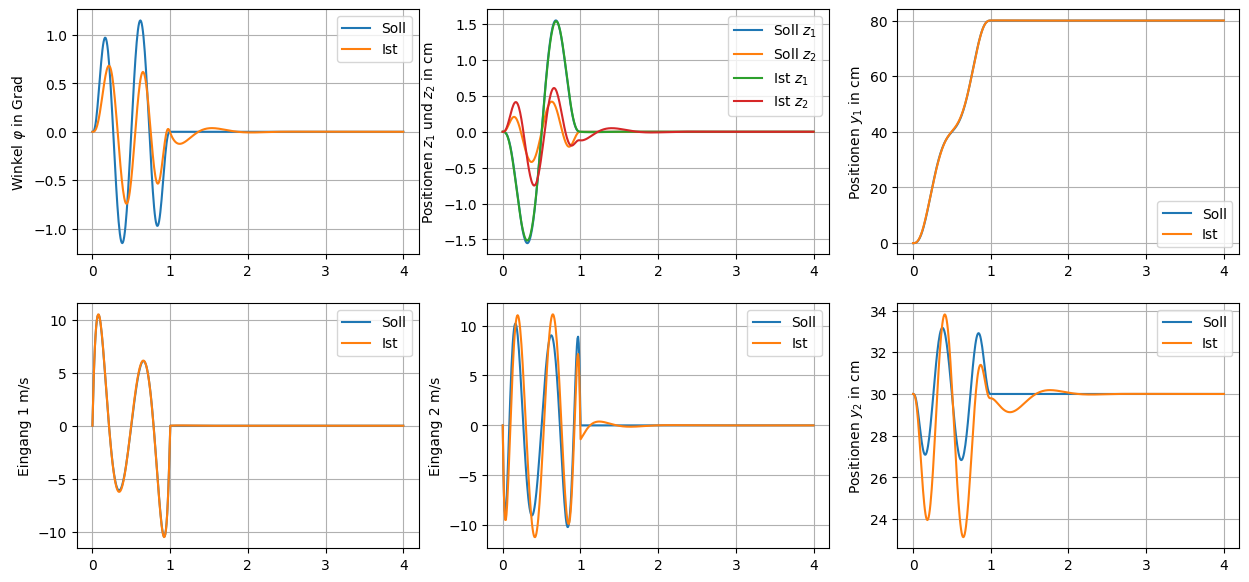

In [10]:
#Anfangszustand
x0=trajectory.state(0).flatten()
#x0[0]=x0[0]+0.1
Tsim=4

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,500)

linear=False
if linear:
 gantry=gantry_lin
else:
 gantry=gantry_nl

#Regler definieren 
controller=LinearStateFeedback(K_pole_placement)

#System verschalten
controller.connect("u_ref",trajectory,"u_ref")
controller.connect("x_ref",trajectory,"x_ref")
controller.connect("x",gantry,"state")
gantry.connect("accell_axis",controller,"u")

#Simulation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,
             (trajectory.state(t_eval),res.y),
             (trajectory.input(t_eval),controller.output(t_eval,x)),
             (trajectory.output(t_eval,"position_total"),gantry.output(t_eval,x,"position_total")))

## 2.3 LQR Entwurf

### 2.3.1 Berechnen der Reglerverstärkung

#### Ergänzen Sie hier Ihre Überlegungen zu Aufgabe 2e) und passen Sie den Code der nächsten Zelle entsprechend an.

In [11]:
import gantry as module_gantry
imp.reload(module_gantry)
imp.reload(pysim)

#lineares Modell
from pysim import LinearizedSystem

K_lqr=np.zeros((2,10))

print("Reglerverstärkung:")
display(sympy.Matrix(K_lqr.round(3)))


print("Probe (Eigenwerte geschlossener Kreis):")
display(sympy.Matrix(np.linalg.eigvals(gantry_lin.A()-gantry_lin.B()@K_lqr).round(3)).transpose())

Reglerverstärkung:


Matrix([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Probe (Eigenwerte geschlossener Kreis):


Matrix([[9.582*I, -9.582*I, 6.045*I, -6.045*I, 6.086*I, -6.086*I, 0, 0, 0, 0]])

### 2.3.2. Simulationsstudien

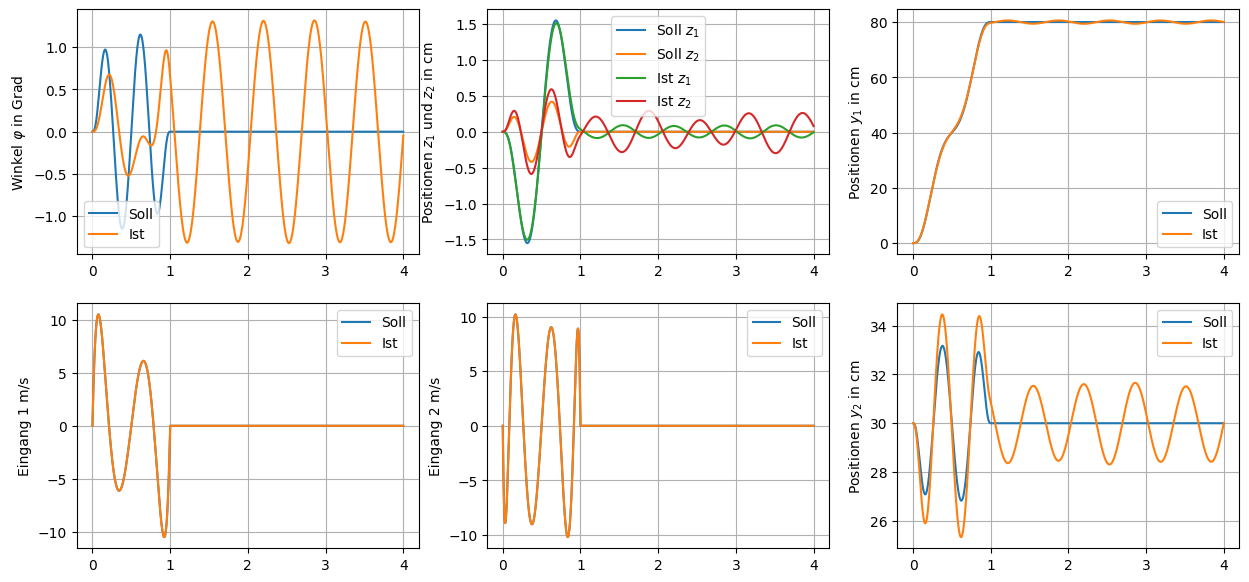

In [12]:
#Reglerverstärkung setzen
controller.set_gain(K_lqr)


#Anfangszustand
x0=trajectory.state(0).flatten()

Tsim=4

#Auswertungszeitpunkte 
t_eval=np.linspace(0,Tsim,1000)
linear=False
if linear:
 gantry=gantry_lin
else:
 gantry=gantry_nl

#System verschalten
controller.connect("u_ref",trajectory,"u_ref")
controller.connect("x_ref",trajectory,"x_ref")
controller.connect("x",gantry,"state")
gantry.connect("accell_axis",controller,"u")

#Simulation
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,Tsim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=res.y
plot_results(t_eval,
            (trajectory.state(t_eval),res.y),
            (trajectory.input(t_eval),controller.output(t_eval,x)),
            (trajectory.output(t_eval,"position_total"),gantry.output(t_eval,x,"position_total")))

# 3 Beobachterentwurf

#### Fügen Sie hier hier Ihre überlegungen zu Teilaufgabe 3a) ein

Um zu überprüfen ob der Zustand vollständig Rekonstruierbar bzw. vollständig Beobachtbar ist, müssen wir die folgende Bedigung prüfen.

- Die Kalmansche Beobachtbarkeitsmatrix besitzt den Rang $n$.

Ein LTI-System ist immer Erreichbar wenn es auch Beobachtbar ist und umgekehrt. Für die Überprüfung wir die kalmansche Beobachtbarkeitsmatrix verwendet. Diese kann aus der Funtion `controllability_matrix` durch Transponieren der Matrixen berechnet werden.

In [13]:
from mimo import controllability_matrix 

A = gantry_lin.A().copy()
C = gantry_lin.C('position_axis').copy()

O = controllability_matrix(A.transpose(),C.transpose()).transpose()

print('Rang der Beobachtbarkeitsmatrix:')
print(np.linalg.matrix_rank(O))

Rang der Beobachtbarkeitsmatrix:
4


Der Rang der Matrix entspricht nicht der Zustandsdimension. Das System ist somit nicht Rekonstruierbar.

## 3.1 Adaptiertes Modell

### 3.1.1. Zusätzliche Sensorik

#### Fügen Sie hier hier Ihre Überlegungen zu Teilaufgabe 3b) ein. 
Die Winkelgeschwindigkeit kann durch die Annahme $y_{m,3}=\dot{\varphi}$ direkt aus der Modellgleichung bestimmt werden.\
Die Beschleunigungen $\bar{u}_1 = \ddot{z}_1$ und $\bar{u}_2 = \ddot{z}_2$ können durch einmaliges Ableiten der Modellgleichung nach der Zeit bestimmt werden.

Modellgleichung:
\begin{align}
\mathbf{\dot{z}} = \begin{bmatrix}\dot{z}_1  \\ \dot{z}_2 \\
\dot{\varphi}\end{bmatrix};
\mathbf{x} = \begin{bmatrix}x_6  \\ x_7\end{bmatrix};
\mathbf{N} = \begin{bmatrix}
m & 0 \\
0 & m \\
-m \overline{x}_2 & m \overline{x}_1
\end{bmatrix};
\mathbf{x} = \begin{bmatrix}x_6  \\ x_7\end{bmatrix};
\mathbf{p} = \begin{bmatrix}p_1  \\ p_2 \\p_{\varphi}\end{bmatrix}
\end{align}\
\begin{align}
\mathbf{M} \mathbf{\dot{z}} = - \mathbf{N} \mathbf{x} + \mathbf{p}
\end{align}

Winkelgeschwindigkeit $\dot{\varphi}$:
\begin{align}
\begin{bmatrix}\dot{z}_1  \\ \dot{z}_2 \\
\dot{\varphi}\end{bmatrix} = \mathbf{\dot{z}} =\mathbf{M^{-1}} (- \mathbf{N} \mathbf{x} + \mathbf{p})
\end{align}

Beschleunigungen $\bar{u}_1 = \ddot{z}_1$ und $\bar{u}_2 = \ddot{z}_2$: ( Ableiten mittels Produktregel)

\begin{align}
\mathbf{M} \mathbf{\ddot{z}} + \mathbf{\dot{M}} \mathbf{\dot{z}} = - \mathbf{\dot{N}} \mathbf{\dot{x}}- \mathbf{N} \mathbf{\ddot{x}}+ \mathbf{p}
\end{align}

\begin{align}
\begin{bmatrix}\ddot{z}_1  \\ \ddot{z}_2 \\
\ddot{\varphi}\end{bmatrix} = \mathbf{\ddot{z}} = \mathbf{M^{-1}} (-\mathbf{\dot{M}} \dot{z} - \mathbf{\dot{N}} \mathbf{\dot{x}}- \mathbf{N} \mathbf{\ddot{x}}+ \mathbf{p})
\end{align}

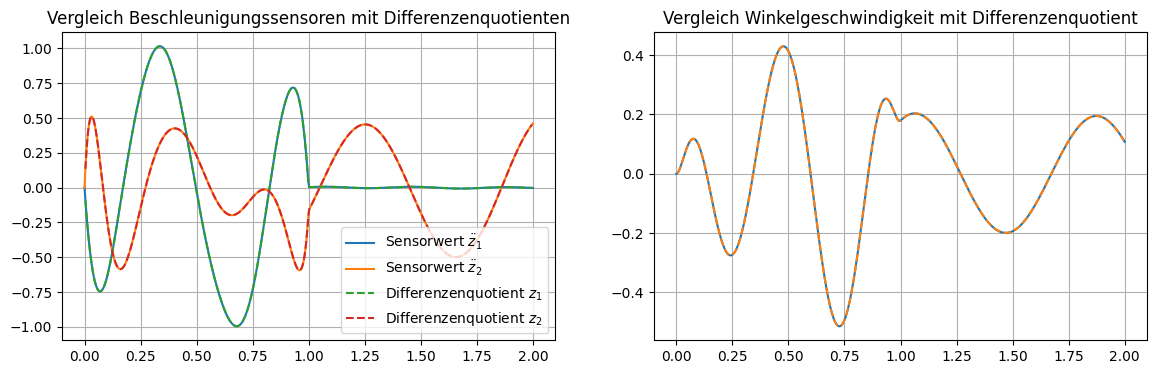

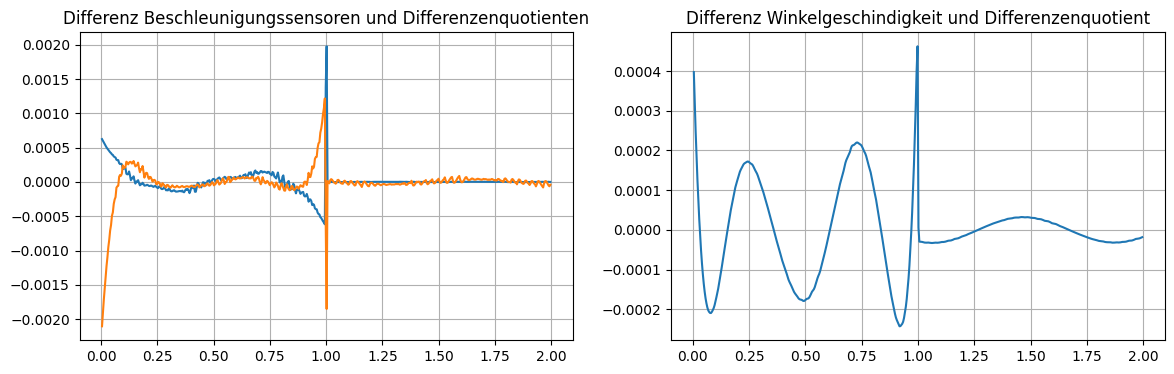

In [14]:
#Modell neu laden
import gantry as module_gantry
import pysim
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, plot_results, RigidTrajectory;

##Nichtlineares Modell initialisieren
gantry_nl=Gantry()
gantry_lin=gantry.linearize(equi_lin)

linear=False

if linear:
    gantry=gantry_lin
else:
    gantry=gantry_nl

#Starr geplante Trajektorie
trajectory_rigid=RigidTrajectory(equis[1],equis[3],T,[2,2])

#System Verschalten
gantry.connect('accell_axis',trajectory,'u_ref')

#Anfangsbedingungen
x0 = np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=2*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Simulieren
res = solve_ivp(gantry.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Zustand auslesen
x=res.y

##Sensoren auswerten 
ddz=gantry.output(t_eval,x,'accell_frame')
dphi=gantry.output(t_eval,x,'gyro_frame')

##Differenzenquotienten Beschleunigung berechnen
dt=t_eval[1]-t_eval[0]
ddz_approx=(x[2:4,2:]-2*x[2:4,1:-1]+x[2:4,0:-2])/dt**2
dphi_approx=(x[4,2:]-x[4,0:-2])/dt/2
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.grid()
plt.plot(t_eval,ddz[0,:],label="Sensorwert $\\ddot{z}_1$")
plt.plot(t_eval,ddz[1,:],label="Sensorwert $\\ddot{z}_2$")
plt.plot(t_eval[1:-1], ddz_approx[0,:], '--', label = "Differenzenquotient $z_1$")
plt.plot(t_eval[1:-1], ddz_approx[1,:], '--', label = "Differenzenquotient $z_2$")
plt.legend()
plt.title("Vergleich Beschleunigungssensoren mit Differenzenquotienten")

plt.subplot(1,2,2)
plt.grid()
plt.plot(t_eval,dphi[0,:],label="Sensorwert $\\ddot{\varphi}$")
plt.plot(t_eval[1:-1],dphi_approx,'--', label="Differenzenquotient $\\ddot{\varphi}$")
plt.title("Vergleich Winkelgeschwindigkeit mit Differenzenquotient")

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.grid()
plt.plot(t_eval[1:-1], ddz_approx[0,:]-ddz[0,1:-1], label = "Fehler $\\ddot{z}_1$")
plt.plot(t_eval[1:-1], ddz_approx[1,:]-ddz[1,1:-1], label = "Fehler $\\ddot{z}_2$")
plt.title("Differenz Beschleunigungssensoren und Differenzenquotienten")
plt.subplot(1,2,2)
plt.grid()
plt.plot(t_eval[1:-1], dphi_approx[:]-dphi[0,1:-1], label = "Fehler $\\dot{\varphi}$")
plt.title("Differenz Winkelgeschindigkeit und Differenzenquotient")
plt.show()


### 3.1.2. Beobachtermodell


#### Fügen Sie hier hier Ihre Überlegungen zu Teilaufgabe 3c) ein.
Zum Aufstellen des neuen Zustandsraummodells werden die Matrizen so umgestellt, dass die Beschleunigungen des Schlittens $ \ddot{x}_1 $ und $ \ddot{x}_2 $ sowie die Windelbeschleunigung der Platte $ \ddot{\varphi} $ in einem Vektor stehen, sodass zu dessen Berechnung nach diesem umgestellt werden kann. Die nun gemessenen Beschleunigungen $ \ddot{z}_1 , \ddot{z}_2 $ werden als Eingang verwendet.  

\begin{align}
\dot{x}_1 &= x_6 \\
\dot{x}_2 &= x_7 \\
\dot{z}_1 &= x_8 \\
\dot{z}_2 &= x_9 \\
\dot{\varphi} &= x_{10} \\
\mathbf{M}(x)
\begin{bmatrix}
\ddot{x}_1  \\ \ddot{x}_2 \\ \ddot{\varphi}
\end{bmatrix}
&= \dot{p} - \dot{M}(x)
\begin{bmatrix}
x_6 \\
x_7 \\
x_{10} \\
\end{bmatrix}
-
M_2(x)
\begin{bmatrix}
\ddot{z}_1  \\ \ddot{z}_2 
\end{bmatrix}
-
\dot{M}_2(x)
\begin{bmatrix}
\dot{z}_1  \\ \dot{z}_2 
\end{bmatrix}\\
\ddot{z}_1 &= u_1 \\
\ddot{z}_2 &= u_2 \\
\end{align}


**Massenmatrizen:**
$$
\mathbf{M}(x) = m 
\begin{bmatrix}
\cos(\varphi) & -\sin(\varphi) & - (x_1 \sin(\varphi) + x_2 \cos(\varphi))\\
\sin(\varphi) & \cos(\varphi) & (x_1 \cos(\varphi) - x_2 \sin(\varphi)) \\
- x_2  &  x_1 & J_{R}/m + \left(x_1^{2} + x_2^{2}\right)
\end{bmatrix}
$$


$$
\mathbf{M}_2(x) =
\begin{bmatrix}
m+M & 0 \\
0 & m+M\\
-m(x_1 \sin(\varphi) + x_2 \cos(\varphi) & m(x_1 \cos(\varphi) - x_2 \sin(\varphi)
\end{bmatrix}
$$

$$
\mathbf{\dot{M}}_2(x) =
\begin{bmatrix}
0 & 0 \\
0 & 0\\
-m(\dot{x}_1 \sin(\varphi) + \dot{x}_2 \cos(\varphi) + x_1 \cos(\varphi) \dot{\varphi}- x_2 \sin(\varphi) \dot{\varphi})& 
-m(\dot{x}_1 \cos(\varphi) - \dot{x}_2 \sin(\varphi) - x_1 \sin(\varphi) \dot{\varphi}- x_2 \cos(\varphi) \dot{\varphi}
)\end{bmatrix}
$$

Aus Platzgründen wird die Ableitung der Massenmatrix $M$ sowie der Vektor $ \dot{p} $ hier nicht dargestellt. Diese ist sind im Ordner .assets als Bilddatei dargestellt.

**Umstellen nach dem zu berechnenden Vektor**

\begin{align}
\begin{bmatrix}
\ddot{x}_1  \\ \ddot{x}_2 \\ \ddot{\varphi}
\end{bmatrix}
&= 
\mathbf{M^{-1}}(x) \Bigg(\dot{p} - \dot{M}(x)
\begin{bmatrix}
x_6 \\
x_7 \\
x_{10} \\
\end{bmatrix}
-
M_2(x)
\begin{bmatrix}
\ddot{z}_1  \\ \ddot{z}_2 
\end{bmatrix}
-
\dot{M}_2(x)
\begin{bmatrix}
\dot{z}_1  \\ \dot{z}_2 
\end{bmatrix} \Bigg) \\
\end{align}

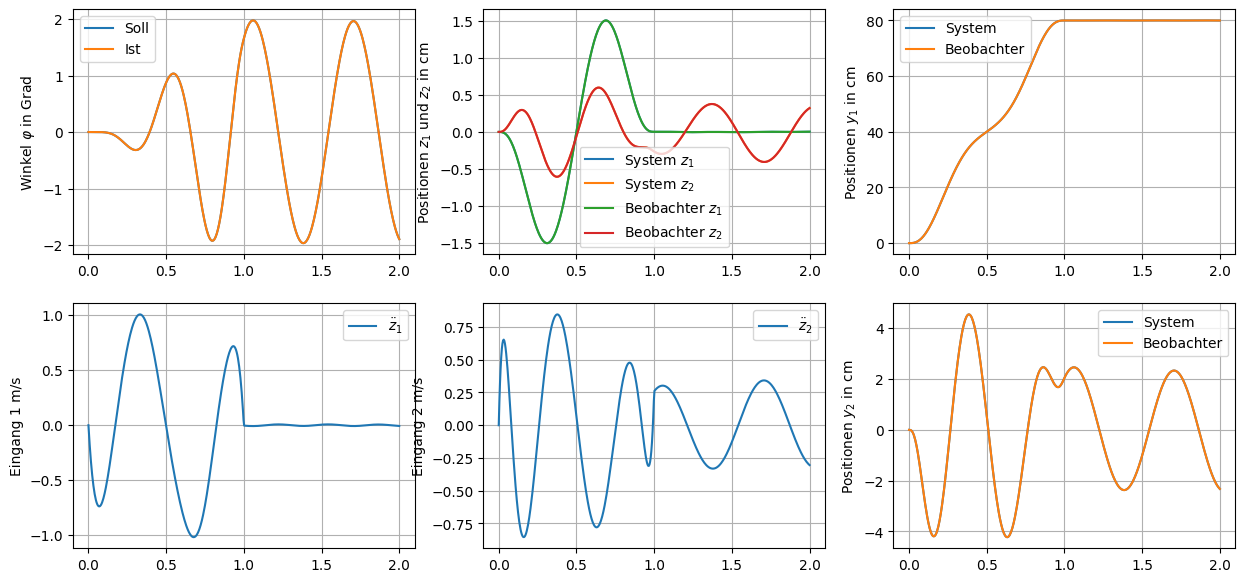

In [15]:
#Modell neu laden
import gantry as module_gantry
import pysim as module_gantry
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, GantryObserver, GantryObserverModel, plot_results, RigidTrajectory;
from pysim import CompoundSystem

#Modell des Brückenkrans initialisieren
gantry_nl=Gantry()
gantry=gantry_nl

#Modell des Beobachters initialisieren
observer_model=GantryObserverModel(gantry_nl);

##Gesamtsystem bauen
observed_gantry=CompoundSystem()
observed_gantry.add_system(gantry,"Systemmodell")
observed_gantry.add_system(observer_model,"Beobachter")
observed_gantry.add_system(trajectory,"Steuerung")

gantry.connect('accell_axis',trajectory,'u_ref')
observer_model.connect('accell_frame',gantry,'accell_frame')

# Anfangs- und Endwerte für die Schlittenposition (absolut) 
ya = equis[0]
yb = equis[1]

#Anfangsbedingungen
trajectory_rigid=RigidTrajectory(ya,yb,T,[2,2])

#Anfangsbedingungen für beide Systeme in Dictionary
x0_ = {gantry.get_name():np.array([ya[0],ya[1],0,0,0,0,0,0,0,0]),
       observer_model.get_name():np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])}

#Anfangsbedingungen in Vektor umwandeln
x0=observed_gantry.assemble_state(x0_)

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=2*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Wrapper für rechte Seite der Differentialgleichung
res = solve_ivp(observed_gantry.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Zustände der Teilsysteme auspacken
x=observed_gantry.disassemble_state(res.y)
x_obs=x["Beobachter"]
x_sys=x["Systemmodell"]

#Ergebnisse Plotten
plot_results(t_eval,
             (x_sys,x_obs),
             (gantry.output(t_eval,x,'accell_frame'),),
             (gantry.output(t_eval,x,'position_total'),observer_model.output(t_eval,x,'position_total')))

ax=plt.subplot(2,3,2)
ax.legend(["System $z_1$", "System $z_2$", "Beobachter $z_1$", "Beobachter $z_2$"])
ax=plt.subplot(2,3,4)
ax.legend(["$\\ddot{z}_1$"])
ax=plt.subplot(2,3,5)
ax.legend(["$\\ddot{z}_2$"])
ax=plt.subplot(2,3,3)
ax.legend(["System","Beobachter"])
ax=plt.subplot(2,3,6)
ax.legend(["System","Beobachter"])

## 3.2 Beobachtbarkeit
### Linearisierung

#### Ergänzen Sie Ihre Überlegungen zu Teilaufgabe 3d hier
Das erhaltene Zustandsraummodell lässt sich im Wesentlichen analog zur Aufgabe 1b) bzw. Abschnitt 1.2.1. linearisieren. Eine Besonderheit sind die Linearisierungen der abgeleiteten Matrizen $\dot{M}$ und $\dot{M}_2$ (Vgl. Aufgabe 3c) bzw. Abschnitt 3.1.2.) .In der Ruhelage sind die zeitlichen Änderung aller Variablen bzw. alle Geschwindigkeiten gleich Null. Da in den beiden Matrizen jeder Eintrag jeweils mit mindestens einer Geschwindigkeitsvariablen multipliziert wird, werden diese Einträge ebenfalls zu Null. Dies ist darauf zurückzuführen, dass beim Linearisieren einer Gleichung, in die jeweiligen partiellen Ableitungen die Werte der Ruhelage eingesetzt werden.

\begin{align}
\dot{\tilde{x}}_1 &= \tilde{x}_6 \\
\dot{\tilde{x}}_2 &= \tilde{x}_7 \\
\dot{\tilde{z}}_1 &= \tilde{x}_8 \\
\dot{\tilde{z}}_2 &= \tilde{x}_9 \\
\dot{\tilde{\varphi}} &= \tilde{x}_{10} \\
\mathbf{M}(\bar{x})
\begin{bmatrix}
\ddot{\tilde{x}}_1  \\ \ddot{\tilde{x}}_2 \\ \ddot{\tilde{\varphi}}
\end{bmatrix}
&= -
\begin{bmatrix}
4k & 0 & 0\\
0 & 4k&0 \\
0 & 0 & kl^2
\end{bmatrix}
\begin{bmatrix}
\tilde{x}_6 \\ \tilde{x}_7 \\ \tilde{x}_{10}
\end{bmatrix}
-
\begin{bmatrix}
m+M & 0 \\
0 & m+M\\
-m \overline{x}_2 & m \overline{x}_1
\end{bmatrix}
\begin{bmatrix}
\ddot{\tilde{z}}_1  \\ \ddot{\tilde{z}}_2 
\end{bmatrix}\\
\ddot{\tilde{z}}_1 &= \tilde{u}_1 \\
\ddot{\tilde{z}}_2 &= \tilde{u}_2 \\
\end{align}

\begin{align}
\tilde{y}_1 = \tilde{x}_1 + \tilde{z}_1 - \overline{x}_2 \cdot \tilde{\varphi} \\
\tilde{y}_2 = \tilde{x}_2 + \tilde{z}_2 + \overline{x}_1 \cdot \tilde{\varphi}
\end{align}

**Massenmatrix:**

$$
\mathbf{M}(\bar{x}) =
\begin{bmatrix}
m & 0 & - m \bar{x}_2\\
0 & m & m \bar{x_1} \\
- m \bar{x}_2 & m \bar{x_1} & J_{R} + m \left(\overline{x}_1^{2} + \overline{x}_2^{2}\right)
\end{bmatrix}
$$


In [16]:
#Linearisiertes Modell berechnen
observer_model_lin=observer_model.linearize(equis[0])

#Prüfen der Linearisierung
observer_model.verify_linearization(observer_model_lin);

Maximaler absoluter Fehler in Matrix A Zeile 10, Spalte 5 beträgt 1.999467258428922e-11.
Maximaler relativer Fehler in Matrix A Zeile 10, Spalte 5 beträgt 1.6662227153577123e-13.
Maximaler absoluter Fehler in Matrix C_gyro_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_gyro_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_position_axis Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_position_total Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_position_total Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix C_state Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix C_state Zeile 1, Spalte 1 beträgt 0.0.
Maximaler absoluter Fehler in Matrix B_accell_frame Zeile 1, Spalte 1 beträgt 0.0.
Maximaler relativer Fehler in Matrix B_accell_frame Zeile 1, Spalte 1 beträgt 0.0.
Max

### Beobachtbarkeit

#### Ergänzen Sie Ihre Überlegungen zu Teilaufgabe 3e) und 3f) hier

Damit das Mehrgrößensystem vollständig beobachtbar ist, muss analog zum Eingrößensystem die Kalmansche Beobachtbarkeitsmatrix den Rang $n$ besitzen.  Diese wurde mit der `controllability_matrix` Methode berechnet. Anschließend wurde der Rang mit der Numpy-Methode `matrix_rank` berechnet. Der Rang der Beobachtbarkeitsmatrix ist dabei die Summe der Kronecker-Indizes. Diese wurden mit der implementierten Methode `kronecker` bestimmt.

Wie schon zuvor festgestellt kann die Ruhelage eins alleine durch die Werte $y_{m,1-2}$ nicht vollständig rekonstruiert werden. Durch die zusätliche Auswertung des Gyroskops entspricht der Rang der Beobachtbarkeitsmatrix der Zustandsdimmension und ist somit vollständig Rekonstruierbar und Beobachtbar.


In [17]:
import mimo
imp.reload(mimo)

#Analyse der Beobachtbarkeit für die verschiedene Arbeitspunkte
for equi in equis:
    #Linearisiertes Modell berechnen
    _observer_model_lin=observer_model.linearize(equi)

    #Systematrizen aufstellen
    _A=_observer_model_lin.A()

    _C_full=np.vstack((_observer_model_lin.C("position_axis"),_observer_model_lin.C("gyro_frame")))
    
    _C_axis=_observer_model_lin.C("position_axis")

    print("Ruhelage:", equi)
    #Beobachtbarkeitsmatrix aufstellen
    O=mimo.controllability_matrix(_A.transpose(),_C_axis.transpose()).transpose()
    print("Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition:", np.linalg.matrix_rank(O))

    #Berechnung der Kronecker-Indizes
    kroneckers=mimo.kronecker(_A.transpose(),_C_axis.transpose())
    print("Mögliche Kronecker-Indizes:", kroneckers)

    #Beobachtbarkeitsmatrix aufstellen
    O=mimo.controllability_matrix(_A.transpose(),_C_full.transpose()).transpose()
    print("Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops:", np.linalg.matrix_rank(O))
 
    #Berechnung der Kronecker-Indizes
    kroneckers=mimo.kronecker(_A.transpose(),_C_full.transpose())
    print("Mögliche Kronecker-Indizes:", kroneckers)

    print()
        
#np.linalg.svd(Oa, compute_uv=False)

Ruhelage: [0.0, 0.0]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 8
Mögliche Kronecker-Indizes: [4 4]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 10
Mögliche Kronecker-Indizes: [4 4 2]

Ruhelage: [0.0, 0.3]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 10
Mögliche Kronecker-Indizes: [6 4]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 10
Mögliche Kronecker-Indizes: [3 4 3]

Ruhelage: [0.8, 0.0]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 10
Mögliche Kronecker-Indizes: [4 6]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 10
Mögliche Kronecker-Indizes: [4 3 3]

Ruhelage: [0.8, 0.3]
Rang Beobachtbarkeitsmatrix bei Messung der Schlittenposition: 10
Mögliche Kronecker-Indizes: [6 4]
Rang Beobachtbarkeitsmatrix bei zusätzlicher Auswertung des Gyroskops: 10
Mögliche Kronecker-Indizes: [4 3 3]



## 3.3. Beobachterentwurf

#### Ergänzen Sie hier Ihre Überlegungen zu den Teilaufgaben 3g) und 3h) und ergänzen Sie den gegebenen Code in der folgenden Zelle entsprechend

In der Klasse `GantryObserver` wurde der Beobachter in der Methode `model` implementiert. Dazu wird der Schätzfehler $\tilde{y} = \hat{y} - y_{sys}$ mit der Beobachterverstärkung $l$ verstärkt und von der Systemkopie Subtrahiert. $\hat{y}$ ist dabei der Ausgang des Systems und $ y_{sys}$ die gemessenen Sensorwerte $y_{m,1-3}$ der IMU.

Um die Beobachterverstärukung so zu wählen, damit der Schätzfehler $\hat{x}$ gegen Null konvergiert, wurden zunächst die Eigenwerte der linearen Systems berechnet. Damit die Stabilität des Systems sichergestellt ist wurden anschließend alle Realteile um -10 verschoben, sodass sich diese alle auf der linken Halbebene befinden. Anschließend wurde mit der Ackermannformel die entsprechende Beobachterverstärkung berechnet. Da das Vorgehen im wesentlichen der Berechnung der Regelverstärkung entspricht, konnte die bereits vorhande Methode `acker()` verwendet werden, wobei die $A$ - und $C$ - Matrix sowie das Ergebnis jeweils transponiert werden, damit diese der Struktur der Methode entsprechen. 

In [18]:
import mimo
imp.reload(mimo)

#Linearisiertes Modell berechnen
observer_model_lin=observer_model.linearize(equis[0])

#Systematrizen für Beobachterentwurf generieren
A=observer_model_lin.A()
B=observer_model_lin.B()
C=np.vstack((observer_model_lin.C("position_axis"),observer_model_lin.C("gyro_frame")))

#Beobachterverstärkungen festlegen
observer_gain=np.zeros((10,3))
eigs = np.linalg.eigvals(A)
for i in range(len(eigs)):
    eigs[i]=complex(eigs[i].real -10,eigs[i].imag)
eigs = [eigs[:4],eigs[4:8],eigs[8:]]
observer_gain=mimo.acker(A.transpose(),C.transpose(),eigs).transpose()
                       
#Prüfen der Eigenwerte des geschlossenen Regelkreises für die weiteren Ruhelagen
for _equi in equis:
    _observer_model_lin=observer_model.linearize(_equi)
    A=_observer_model_lin.A()
    B=_observer_model_lin.B()
    C=np.vstack([_observer_model_lin.C("position_axis"),_observer_model_lin.C("gyro_frame")])
    print("Eigenwerte Beobachterfehlersystem in Ruhelage: [" + str(_equi[0])+","+str(_equi[1])+"]")
    display(sympy.Matrix(np.linalg.eigvals((A-observer_gain@C)).round(3)).transpose())
    

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.0,0.0]


Matrix([[-10.0 + 10.954*I, -10.0 - 10.954*I, -10.002, -10.0 + 0.002*I, -10.0 - 0.002*I, -9.998, -10.0, -10.0, -10.0, -10.0]])

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.0,0.3]


Matrix([[-8.724 + 12.163*I, -8.724 - 12.163*I, -15.614 + 4.322*I, -15.614 - 4.322*I, -5.662 + 2.313*I, -5.662 - 2.313*I, -10.002, -10.0 + 0.002*I, -10.0 - 0.002*I, -9.998]])

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.8,0.0]


Matrix([[-10.0 + 10.954*I, -10.0 - 10.954*I, -10.0, -10.0, -20.154 + 3.266*I, -20.154 - 3.266*I, -6.787 + 12.163*I, -6.787 - 12.163*I, -3.059 + 1.734*I, -3.059 - 1.734*I]])

Eigenwerte Beobachterfehlersystem in Ruhelage: [0.8,0.3]


Matrix([[-20.399 + 3.25*I, -20.399 - 3.25*I, -6.79 + 13.353*I, -6.79 - 13.353*I, -9.796 + 9.773*I, -9.796 - 9.773*I, -10.0, -10.0, -3.015 + 1.705*I, -3.015 - 1.705*I]])

### Simulation des Systems mit Beobachter

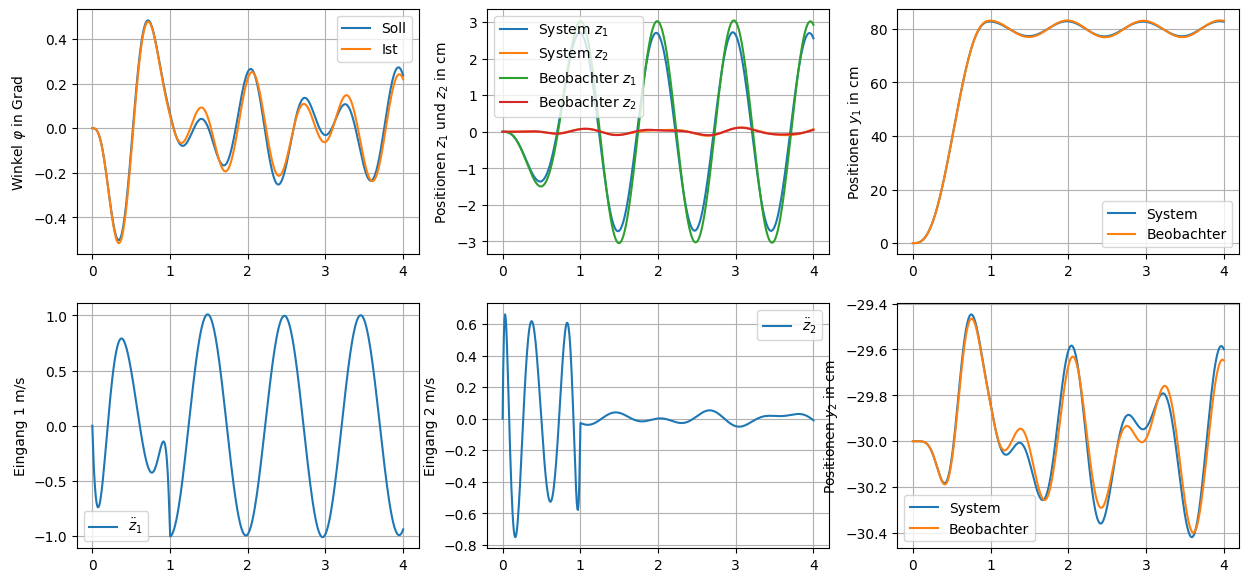

In [19]:
#Module neu laden
import pysim
import gantry as module_gantry
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, GantryObserver, GantryObserver, plot_results, RigidTrajectory
from pysim import CompoundSystem

#Design- und Simulationsmodelle generieren
gantry_sim_nl=Gantry()
gantry_design_nl=Gantry()

#Modellfehler einbauen
model_error=0.1 # relativer Fehler
gantry_sim_nl.k=(1.0+model_error)*gantry_sim_nl.k

#Lineare Modelle generieren
gantry_sim_lin=gantry_sim_nl.linearize(equis[0])
gantry_design_lin=gantry_design_nl.linearize(equis[0])

#Design- und Simulationsmodell auswählen (linear oder nichtlinear)
gantry_design=gantry_design_nl
gantry_sim=gantry_sim_nl

# Solltrajektorie generieren 
ya = equis[1]
yb = equis[3]
trajectory=RigidTrajectory(ya,yb,T,[2,2])

#Beobachter initialisieren
observer=GantryObserver(gantry_design);
observer.set_gain(observer_gain)

#System zusammensetzen
observed_system=CompoundSystem()
observed_system.add_system(gantry_sim,"Systemmodell")
observed_system.add_system(observer,"Beobachter")
observed_system.add_system(trajectory,"Steuerung")

#System verschalten
gantry_sim.connect('accell_axis',trajectory,'u_ref')
observer.connect('accell_frame',gantry_sim,'accell_frame')
observer.connect('position_axis_sys',gantry_sim,'position_axis')
observer.connect('gyro_frame_sys',gantry_sim,'gyro_frame')


#Anfangsbedingungen für Teilsysteme
x0_ = {gantry.get_name():np.array([-0.0,-0.3,0.0,0,0,0,0,0,0,0]),
       observer.get_name():np.array([-0.0,-0.3,0,0,0,0,0,0,0,0])}

#Vektor von Anfangsbedingungen generieren
x0=observed_system.assemble_state(x0_)

#Übergangszeit
T=1.0

#Simulationszeit
T_sim=4*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)

#Simulieren
res = solve_ivp(observed_system.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Ergebnisse Plotten
x=observed_system.disassemble_state(res.y)
x_obs=x["Beobachter"]
x_sys=x["Systemmodell"]

plot_results(t_eval,
             (x_sys,x_obs),
             (gantry.output(t_eval,x,'accell_frame'),),
             (gantry.output(t_eval,x,'position_total'),observer.output(t_eval,x,'position_total')))

ax=plt.subplot(2,3,2)
ax.legend(["System $z_1$", "System $z_2$", "Beobachter $z_1$", "Beobachter $z_2$"])
ax=plt.subplot(2,3,4)
ax.legend(["$\\ddot{z}_1$"])
ax=plt.subplot(2,3,5)
ax.legend(["$\\ddot{z}_2$"])
ax=plt.subplot(2,3,3)
ax.legend(["System","Beobachter"])
ax=plt.subplot(2,3,6)
ax.legend(["System","Beobachter"])

### Simulation geschlossener Regelkreis

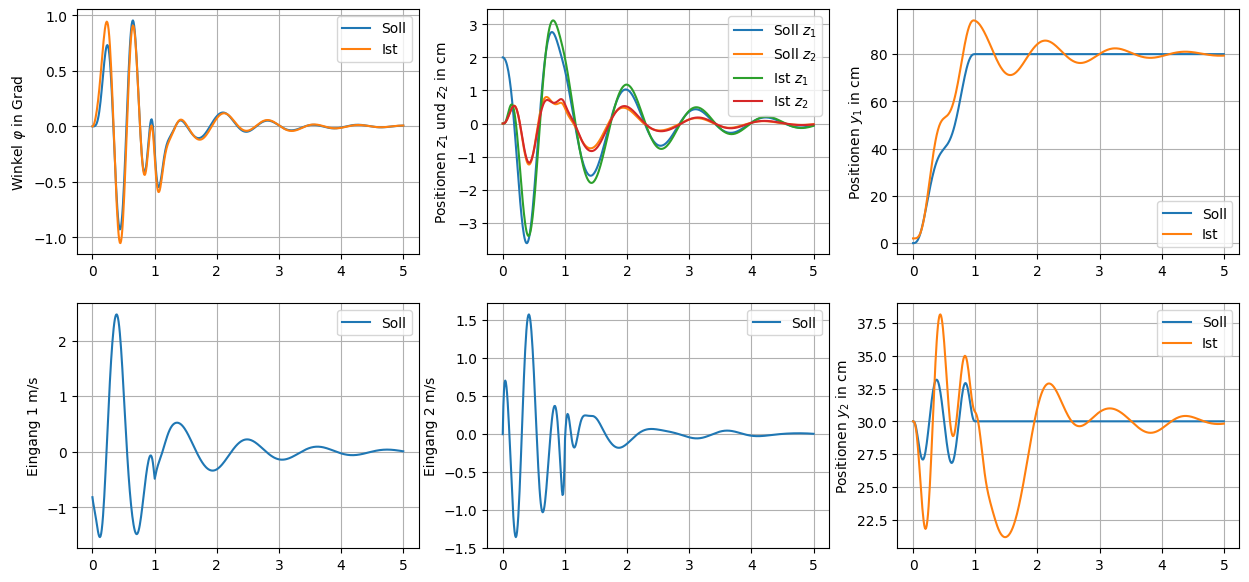

In [20]:
#Modell neu laden
import gantry as module_gantry
import pysim
imp.reload(module_gantry)
imp.reload(pysim)

from gantry import Gantry, GantryObserver, GantryObserver, plot_results, RigidTrajectory
from pysim import LinearStateFeedback, CompoundSystem, ContinuousFlatnessBasedTrajectory

#Nichtlineare Modelle initialisieren
gantry_sim_nl=Gantry()
gantry_design_nl=Gantry()

#Modellfehler
model_error=0.1 # relativer Fehler
gantry_sim_nl.k=(1.0+model_error)*gantry_sim_nl.k

#Lineare Modelle generieren
gantry_sim_lin=gantry_sim_nl.linearize(equi)
gantry_design_lin=gantry_design_nl.linearize(equi)

#Design- und Simulationsmodelle festlegen
gantry_design=gantry_design_nl
gantry_sim=gantry_sim_nl

# Solltrajektorie generieren 
ya = equis[1]
yb = equis[3]
equis_trj={"position_total":{"start":equis[1],"final":equis[3]}}
trajectory=gantry_design_lin.rest_to_rest_trajectory(equis_trj,T,(4,6))

#Regler definieren 
controller=LinearStateFeedback(K_pole_placement)

#Beobachter initialisieren
observer=GantryObserver(gantry_design);
observer.set_gain(observer_gain)

#System zusammensetzen
closed_loop_system=CompoundSystem()
closed_loop_system.add_system(gantry_sim,"Systemmodell")
closed_loop_system.add_system(observer,"Beobachter")
closed_loop_system.add_system(trajectory,"Steuerung")
closed_loop_system.add_system(controller,"Regler")

#System verschalten
gantry_sim.connect('accell_axis',controller,'u')
observer.connect('accell_frame',gantry_sim,'accell_frame')
observer.connect('position_axis_sys',gantry_sim,'position_axis')
observer.connect('gyro_frame_sys',gantry_sim,'gyro_frame')
controller.connect("u_ref",trajectory,"u_ref")
controller.connect("x_ref",trajectory,"x_ref")
controller.connect("x",observer,"state")


#Anfangsbedingungen
x0_ = {gantry.get_name():np.array([ya[0],ya[1],0.02,0,0,0,0,0,0,0]),
       observer.get_name():np.array([ya[0],ya[1],0,0,0,0,0,0,0,0])}
x0=closed_loop_system.assemble_state(x0_)
#Übergangszeit
T=1.0

#Simulationszeit
T_sim=5*T

#Auswertungszeitpunkte 
t_eval=np.linspace(0,T_sim,500)


#Wrapper für rechte Seite der Differentialgleichung
res = solve_ivp(closed_loop_system.model,#zu simulierendes Modell
                [0,T_sim],#Zeitspanne für Simulation
                x0,#Anfangszustand 
                t_eval=t_eval,#Auswertungszeitpunkte
                atol=1e-9,rtol=1e-6 #Toleranzen
                )

#Zustand der Teilsysteme auspacken 
x=closed_loop_system.disassemble_state(res.y)
x_obs=x["Beobachter"]
x_sys=x["Systemmodell"]

#Ergebnisse Plotten
plot_results(t_eval,(x_sys,x_obs),
             (gantry_sim.output(t_eval,x,'accell_frame'),),
             (trajectory.output(t_eval,"position_total"),
              gantry_sim.output(t_eval,x,'position_total')))
